<a href="https://colab.research.google.com/github/ramapriyakj/yelp/blob/master/YelpUnsupervisedAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Integration* with google drive.

In [33]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_set_dir = root_dir + 'Colab Notebooks/dataset/yelp/'

Mounted at /content/gdrive


**Yelp Unsupervised Data Analysis**

In this project we perform clustering on yelp data set (https://www.yelp.com/dataset ).

business.json file is used to perform clustering of restaurants.

Following clustering methods are used

1.   K Means clustering
2.   Hierarchical clustering

Business JSON path

In [0]:
import os,sys
business_path = data_set_dir + "business.json";
if os.path.isfile(business_path):    
    pass
else:
    print("Invalid file path. Please place the python file in the same folder as review.json and rerun.")
    sys.exit(0)

Required libraries

In [0]:
import operator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

Read data:

1.   Read business.json
2.   Retain only city,latitude,longitude,categories columns
3.   Normalize latitude and longitude data
4.   Keep only restaurants in Las Vegas and that have "Restaurants" in categories 
5.   Identify top 20 restaurant categories other than Food, Fast food and bars
6.   For each category in top 20, create boolean column in original dataset indicating the category

In [36]:
categories = {}
header = ["city","latitude","longitude","categories"]
business = pd.read_json(business_path,lines=True)[header]
business = business[(business.city == "Las Vegas") & (business['categories'].str.contains("Restaurants")==True)]
cate = business["categories"]
business = business.drop("city", axis=1)
business = business.drop("categories", axis=1)

latitude = business[['latitude']].values.astype(float)
latitude = (latitude - np.mean(latitude)) / np.std(latitude)
business["latitude"] = latitude

longitude = business[['longitude']].values.astype(float)
longitude = (longitude - np.mean(longitude)) / np.std(longitude)
business["longitude"] = longitude

for record in cate:
    category_string = record.split(sep=",")
    for category in category_string:
        value = category.strip()
        if value not in ['Restaurants','Food','Fast Food','Bars']:
            if value not in categories:
                categories[value] = 1
            else:
                categories[value] += 1
            
sorted_categories = sorted(categories.items(), key=operator.itemgetter(1),reverse=True)

max_category = 20            
sorted_categories = sorted_categories[:max_category]

for i in range(max_category):
    business[i] = 0

index = 0
for ind,data_rec in business.iterrows():
    category_str = cate.iloc[index]
    i = 0
    for category,_ in sorted_categories:
        if category in category_str:
            business.at[ind,i] = 1
        i += 1
    index += 1

print("Top ",max_category," Restaurant categories in Las Vegas :")
print(sorted_categories,end="\n\n")
print("Data shape : ",business.shape)

Top  20  Restaurant categories in Las Vegas :
[('Nightlife', 946), ('American (Traditional)', 896), ('Mexican', 827), ('Sandwiches', 741), ('Pizza', 686), ('American (New)', 677), ('Burgers', 622), ('Breakfast & Brunch', 543), ('Chinese', 475), ('Italian', 454), ('Seafood', 398), ('Japanese', 392), ('Asian Fusion', 328), ('Event Planning & Services', 320), ('Coffee & Tea', 315), ('Sushi Bars', 283), ('Chicken Wings', 269), ('Cafes', 265), ('Salad', 259), ('Steakhouses', 254)]

Data shape :  (6450, 22)


The function plot the cluster graph.

In [0]:
def plotFigure(x_col,y_col,data_object,clusters,centroids,colors,labels,x_label,y_label,title):
    x = 0
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    for i in clusters:
        for j in i:
            plt.scatter(data_object[data_object.columns[x_col]].iloc[j],
                        data_object[data_object.columns[y_col]].iloc[j], color=colors[x])
        x=x+1
    if centroids is not None:
        y = 0    
        for i in centroids:
            plt.scatter(i[x_col],i[y_col],s=50,c='black',marker='*',linewidth=2)
            plt.annotate(labels[y],xy=(i[x_col],i[y_col]))
            y+=1
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend([labels[i] for i in range(len(labels))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    plt.show()

The function returns labels with maximum weight

In [0]:
def get_label(sort_sub,sort_uni):
    max_val = 0
    index = 0
    for key,value in sort_sub:
        temp = value/sort_uni[key][1]
        if(temp>max_val):
            max_val = temp
            index = key
    return sort_uni[index][0]

Total clusters

In [0]:
clusters = 5
color_list = ["cornflowerblue","sandybrown","mediumseagreen","yellow","salmon"]

K-means clustering:

1.   Identify labels and centroids using k-means clustering
2.   Plot the clusters



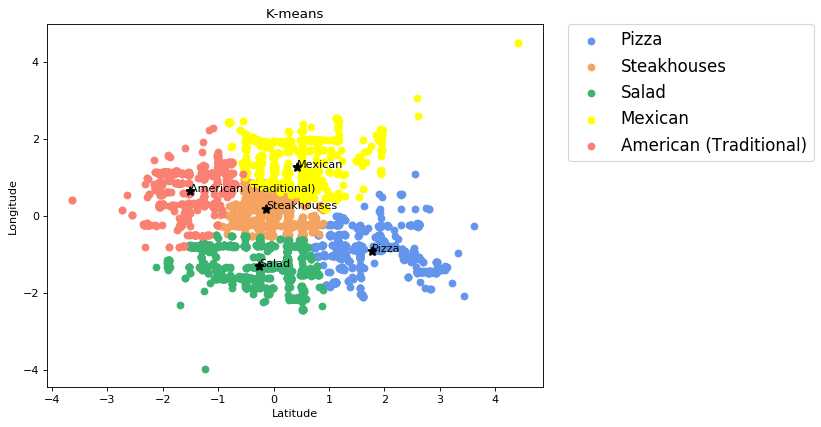

In [40]:
model = KMeans(n_clusters=clusters, n_init=100) 
kmean = model.fit_predict(business)
kmean_centroids = model.cluster_centers_
kmean_labels = model.labels_

kmean_clusters = []
for i in range(clusters):
    kmean_clusters.append(np.where(kmean == i))

kmean_labels = []
for cluster in kmean_clusters:
    category_dict = {}
    for j in range(max_category):
        category_dict[j] = 0
    for l in cluster[0]:
        for j in range(max_category):
            category_dict[j] = category_dict[j] + business.iloc[l][j]
    sorted_cat = sorted(category_dict.items(), key=operator.itemgetter(1),reverse=True)
    kmean_labels.append(get_label(sorted_cat,sorted_categories))
    
plotFigure(0,
           1,
           business,
           kmean_clusters,
           kmean_centroids,
           color_list,
           kmean_labels,
           'Latitude',
           'Longitude',
           'K-means')

AgglomerativeClustering Hierarchical clustering:

1.   Identify clusters using hierarchical clustering
2.   Plot the clusters


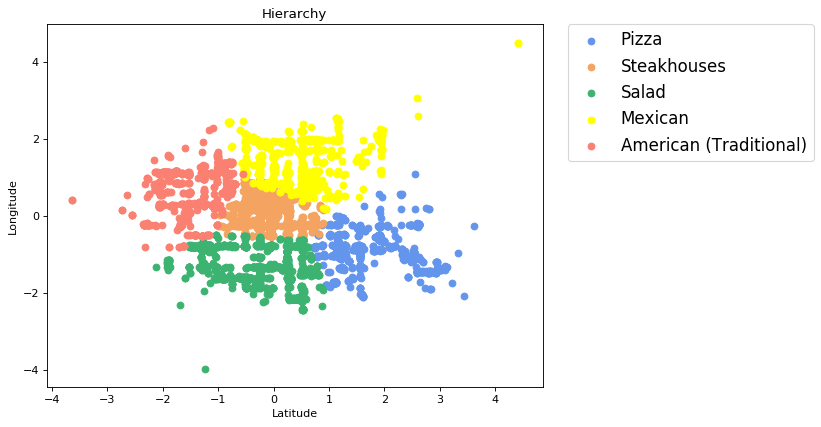

In [41]:
model = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')  
hierarchy = model.fit_predict(business) 

hierarchy_clusters = []
for i in range(clusters):
    hierarchy_clusters.append(np.where(kmean == i))

hierarchy_labels = []
for cluster in hierarchy_clusters:
    category_dict = {}
    for j in range(max_category):
        category_dict[j] = 0
    for l in cluster[0]:
        for j in range(max_category):
            category_dict[j] = category_dict[j] + business.iloc[l][j]
    sorted_cat = sorted(category_dict.items(), key=operator.itemgetter(1),reverse=True)
    hierarchy_labels.append(get_label(sorted_cat,sorted_categories))

plotFigure(0,
           1,
           business,
           hierarchy_clusters,
           None,
           color_list,
           hierarchy_labels,
           'Latitude',
           'Longitude',
           'Hierarchy')